*ÁRBOL DE DECISIÓN CON ATRIBUTOS CATEGÓRICOS*
Ailén de Barbará y Tomás Schiavonne - 4 TIC A



*IMPORTAR TODO LO NECESARIO*

In [1]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import BaggingClassifier


od.download("https://www.kaggle.com/c/titanic/data")
data = pd.read_csv('titanic/train.csv')
print(data.head())

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ailndebarbar
Your Kaggle Key: ··········


100%|██████████| 34.1k/34.1k [00:00<00:00, 26.6MB/s]


Extracting archive ./titanic/titanic.zip to ./titanic
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  


In [2]:
titanic = sns.load_dataset('titanic')

# Identificar las columnas categóricas
categorical_columns = titanic.select_dtypes(include=['object']).columns

# Transformar todas las columnas a numéricas
le = LabelEncoder()
for col in categorical_columns:
    titanic[col] = le.fit_transform(titanic[col].astype(str))

print(titanic.head())

   survived  pclass  sex   age  sibsp  parch     fare  embarked  class  who  \
0         0       3    1  22.0      1      0   7.2500         2  Third    1   
1         1       1    0  38.0      1      0  71.2833         0  First    2   
2         1       3    0  26.0      0      0   7.9250         2  Third    2   
3         1       1    0  35.0      1      0  53.1000         2  First    2   
4         0       3    1  35.0      0      0   8.0500         2  Third    1   

   adult_male deck  embark_town  alive  alone  
0        True  NaN            2      0  False  
1       False    C            0      1  False  
2       False  NaN            2      1   True  
3       False    C            2      1  False  
4        True  NaN            2      0   True  


In [3]:
titanic_numeric = titanic.select_dtypes(include=['float64', 'int64'])
titanic_numeric['sex'] = titanic['sex']
titanic_numeric = titanic_numeric.dropna()

# Elegimos Sex como la variable a predecir
X = titanic_numeric.drop(columns=['sex'])
y = titanic_numeric['sex']
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Crear el modelo
dt_model = DecisionTreeClassifier(random_state=seed)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

*EVALUAR EL MODELO*

In [4]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9300699300699301


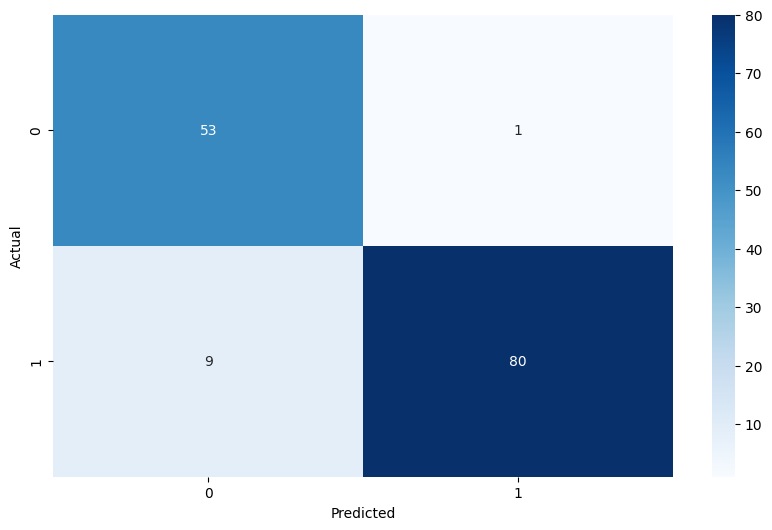

              precision    recall  f1-score   support

           0       0.85      0.98      0.91        54
           1       0.99      0.90      0.94        89

    accuracy                           0.93       143
   macro avg       0.92      0.94      0.93       143
weighted avg       0.94      0.93      0.93       143



In [5]:
# Confussion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
_ = plt.xlabel("Predicted")
_ = plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred))

*HIPERPARAMETROS*

In [6]:
# Definir el rango de hiperparámetros a explorar
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Aplicar GridSearchCV con validación cruzada (5 particiones)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_tree = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}


*UTILIZAR LOS HIPERPARAMETROS PARA MEJORAR EL ÁRBOL*

In [7]:
# Árbol con los nuevos hiperparámetros
best_dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=10,
    min_samples_split=2,
    random_state=seed
)

best_dt_model.fit(X_train, y_train)
y_pred = best_dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuaracy con nuevos hiperparametros: {accuracy}")

Accuaracy con nuevos hiperparametros: 0.9370629370629371


*CROSS VALIDATION*

In [8]:
scores = cross_val_score(dt_model, X, y, cv=5)

In [9]:
print("Scores en cada fold:", scores)
print("Promedio del score:", scores.mean())

Scores en cada fold: [0.95104895 0.93706294 0.95804196 0.95804196 0.92957746]
Promedio del score: 0.9467546537969073


*EVALUACIÓN DE PERFORMANCE CON ROC AUC*

In [10]:
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [12]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.9401789429879317


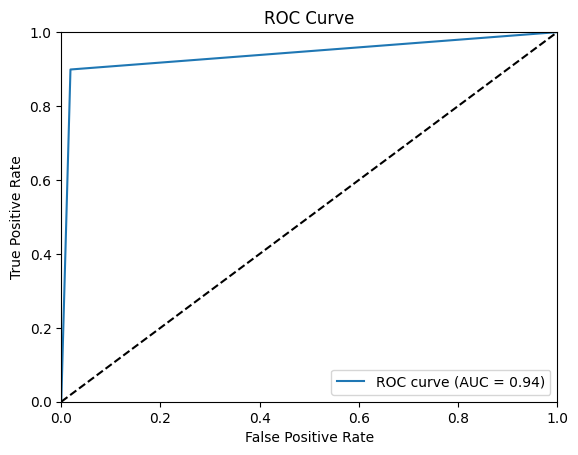

In [13]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

*MOSTRAR "FEATURE IMPORTANCE"*

In [15]:
# Eliminamos la columna 'alive' ya que no tiene importancia
X = titanic.drop(columns=['alive'])

In [16]:
X = titanic.select_dtypes(include=['int64', 'float64'])
feature_names = X.columns

# Obtener la importancia de los atributos
importancia_atributos = dt_model.feature_importances_

# Verifica la longitud de las importancia y los nombres de los atributos
if len(feature_names) != len(importancia_atributos):
    print(f"Longitud de atributos: {len(feature_names)}, Longitud de importancia: {len(importancia_atributos)}")

# Crear un DataFrame para mostrar la importancia de los atributos
importancia_df = pd.DataFrame({'Atributo': feature_names[:len(importancia_atributos)],
                                'Importancia': importancia_atributos})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
print(importancia_df)

Longitud de atributos: 11, Longitud de importancia: 10
      Atributo  Importancia
7     embarked     0.760914
2          sex     0.148250
5        parch     0.044504
3          age     0.020034
1       pclass     0.010143
0     survived     0.007720
6         fare     0.005705
4        sibsp     0.002731
8          who     0.000000
9  embark_town     0.000000


In [17]:
# Verificar el tamaño de las características y las importancias
print(f"feature_names (columnas numéricas): {len(feature_names)}")
print(f"importancia_atributos: {len(importancia_atributos)}")

# Comparar nombres y las importancias
print("Columnas utilizadas:", feature_names)
print("Importancias:", importancia_atributos)

feature_names (columnas numéricas): 11
importancia_atributos: 10
Columnas utilizadas: Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'who', 'embark_town', 'alive'],
      dtype='object')
Importancias: [0.00771985 0.01014266 0.14825039 0.02003352 0.00273072 0.04450411
 0.00570525 0.76091351 0.         0.        ]


In [18]:
print(len(importancia_atributos))  # Cantidad de importancias
print(len(feature_names))  # Cantidad de atributos

10
11


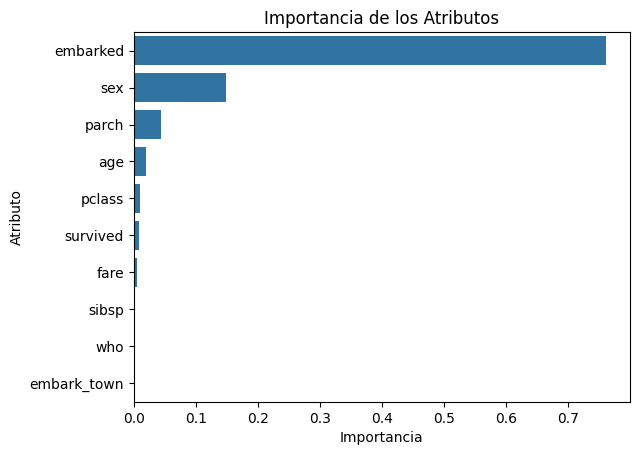

In [19]:
sns.barplot(x='Importancia', y='Atributo', data=importancia_df)
plt.title('Importancia de los Atributos')
plt.show()

*BONUS* --> *BAGGING*

In [25]:
decision_tree = DecisionTreeClassifier()

bagging_clf = BaggingClassifier(
    estimator=decision_tree,
    n_estimators=50,
    random_state=42
)

In [24]:
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo Bagging con árbol de decisión: {accuracy:.2f}')

Precisión del modelo Bagging con árbol de decisión: 0.93
